In [173]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation, PillowWriter
import random
import os

# Update in a loop & Fit

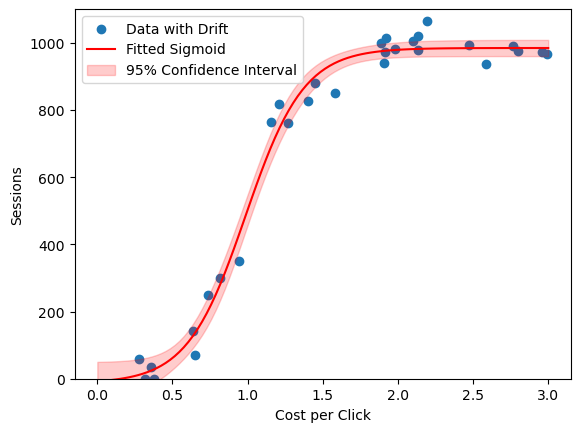

In [182]:
def generate_data(n_points=30, k=1, xmin = 0, xmax=3):
    np.random.seed(42)
    x = np.array([random.uniform(xmin, xmax) for _ in range(n_points)])
    y = 1000 / (1 + np.exp(-5 * (x - k)))  # Sigmoid function scaled to 1000
    y += 50 * np.random.normal(size=n_points)  # Add noise
    drift_values = np.random.normal(size=n_points).cumsum()
    y += drift_values  # Add drift
    y = np.clip(y, a_min=0, a_max=10000)
    return x, y

# Define sigmoid function
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Generate data
x, y = generate_data()

# Initial guess for parameters
p0 = [max(y), np.median(x), 1, min(y)]

# Fit the sigmoid function to the data
params, covariance = curve_fit(sigmoid, x, y, p0, method='dogbox')

# Compute the standard errors of the parameters
perr = np.sqrt(np.diag(covariance))

# Define prediction and uncertainty functions
def predict_with_uncertainty(x, model, params, covariance, n_sigma=1.96):
    """ Predict values with uncertainty bounds using the model """
    # Prediction
    y_pred = model(x, *params)
    
    # Calculate Jacobian
    J = np.zeros((len(x), len(params)))
    for i in range(len(params)):
        perturbed_params = np.copy(params)
        perturbed_params[i] += 1e-8
        J[:, i] = (model(x, *perturbed_params) - y_pred) / 1e-8
    
    # Calculate standard error of the prediction
    y_err = np.sqrt(np.sum(J @ covariance * J, axis=1)) * n_sigma
    
    return y_pred, y_err

# Get predictions and uncertainty bounds
x_=np.linspace(0,3,100)
y_pred, y_err = predict_with_uncertainty(x_, sigmoid, params, covariance)

# Create figure and axis for the plot
fig, ax = plt.subplots()
scat = ax.scatter(x, y, label='Data with Drift')
line, = ax.plot(x_, y_pred, label='Fitted Sigmoid', color='red')

# Plot uncertainty region
ax.fill_between(x_, y_pred - y_err, y_pred + y_err, color='red', alpha=0.2, label='95% Confidence Interval')

# Set plot labels and limits
ax.set_xlabel('Cost per Click')
ax.set_ylabel('Sessions')
ax.set_ylim(0, 1100)  # Adjust y-axis limit to properly display data
ax.legend()

# Display the plot for verification
plt.show()

In [195]:
from PIL import Image

# List to store image frames
frames = []
df_data = pd.DataFrame(zip(x,y), columns = ['x', 'y']).sample(frac=1).reset_index(drop=True)

for i in range(25):
    # Add a new data point
    x_, y_ = generate_data(1, k=1.3, xmin=0.3)
    new_data = pd.DataFrame({'x': x_, 'y': y_})
    df_data = pd.concat([df_data, new_data], ignore_index=True)
    
    # Create a new figure for the current frame
    plt.figure(figsize=(10, 6))
    
    # Plot all points (original and new) in blue
    plt.scatter(df_data.x, df_data.y, color='b', label='Current Data Points')
    
    # Plot the new data points in orange
    plt.scatter(df_data.x.iloc[-1], df_data.y.iloc[-1], color='orange', label='New Data Point')
    
    df_data = df_data.drop(0).reset_index(drop=True)

    # Fit
    # try:
    p0 = [max(df_data.y), np.median(df_data.x), 1, min(df_data.y)]
    # param_bounds = (
    #     [0, 0, 0, 1],  # Lower bounds for [M, K, p]
    #     [1500, 5, 10, 1.1]  # Upper bounds for [M, K, p]
    # )
    params, covariance = curve_fit(sigmoid, df_data.x, df_data.y, p0, method='dogbox', maxfev=1000)
    perr = np.sqrt(np.diag(covariance))
    x_fit = np.linspace(0, 3, 100)
    y_pred, y_err = predict_with_uncertainty(x_fit, sigmoid, params, covariance)
    # except:
    #     continue
    
    plt.plot(x_fit, y_pred, label='Fitted Sigmoid', color='red')
    plt.fill_between(x_fit, y_pred - y_err, y_pred + y_err, color='red', alpha=0.2, label='95% Confidence Interval')
    plt.ylim(0, 1100)
    
    # Set plot labels and title
    plt.xlabel('Cost per Click')
    plt.ylabel('Sessions')
    plt.legend()
    
    frame_filename = f'temp_frame_{i}.png'
    plt.savefig(frame_filename)
    plt.close()

    # Check if the file is saved properly
    try:
        with Image.open(frame_filename) as img:
            img.verify()  # Verify that it's an image
        frames.append(Image.open(frame_filename))
        os.remove(frame_filename)
    except (IOError, OSError) as e:
        print(f"Error opening or verifying image file {frame_filename}: {e}")

frames[0].save('animation.gif', save_all=True, append_images=frames[1:], optimize=False, duration=500, loop=0)
